In [1]:
# ----------------------------------------------------------------------------*
# SEIS 764 Artificial Intelligence
# Assignment 6 :  RNN, LSTM, GRU
# auther: Yann Mulonda - November 20, 2021
# ----------------------------------------------------------------------------*
# Import the libraries needed
import numpy as np
import pandas as pd
from glob import glob
import sys, os, zipfile
import tensorflow as tf
from google.colab import auth
import matplotlib.pyplot as plt
from keras.models import Sequential
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import SGD, Adam
from oauth2client.client import GoogleCredentials
from tensorflow.keras.layers import Input, SimpleRNN, GRU
from tensorflow.keras.layers import LSTM, Dense, Flatten, GlobalMaxPool1D

In [2]:
# check which runtime GPU I'm using
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# ----------------------------------------------------------------------------*
def datasetInfo(data):
  # show dataset info
  print(data.info())
  # show dataset info - describe dataset
  print(data.describe())
  # show dataset info - top 10 rows
  print(data.head(10))

In [4]:
# ----------------------------------------------------------------------------*
# Download the data file saved in the Drive 
!pip install -U -q PyDrive

#File ID
file_id = '1WxkT_jgBlScTZVEmdE27VI0Bq0GPazyY'

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the humidity.csv file
downloaded = drive.CreateFile({'id':file_id})   
downloaded.GetContentFile('humidity.csv')   

In [5]:
# Get and Read data
data = pd.read_csv('humidity.csv')
datasetInfo(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   humidity  3650 non-null   float64
dtypes: float64(1)
memory usage: 28.6 KB
None
          humidity
count  3650.000000
mean     11.177753
std       4.071837
min       0.000000
25%       8.300000
50%      11.000000
75%      14.000000
max      26.300000
   humidity
0      20.7
1      17.9
2      18.8
3      14.6
4      15.8
5      15.8
6      15.8
7      17.4
8      21.8
9      20.0


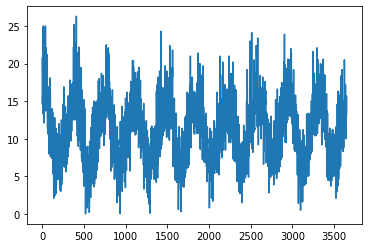

(3650,)

In [6]:
# plot it
#Generating synthetic data of the form sin(kt^2)
humidity_data = data['humidity']
# series = np.sin(humidity_data**2)
series = humidity_data
plt.plot(series)
plt.show()

series.shape

In [7]:
# Build the dataset
# We will use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make the data: N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (3640, 10) Y.shape (3640,)


In [23]:
#-------------------------------------------------------------------------*
# Build the Model
def buildModel(T, D, model_type):
  numberofunit = 50

  # chang the number of unit has a insignificant impact on the model result
  if model_type is 'autoregressive':
    print('Building Auto Regressive Linear Model...')
    i = Input(shape=(T,))
  elif model_type is 'SimpleRNN':
    print('Building Simple RNN Model...')
    i = Input(shape=(T, D))
    # the model is not doing well with relu activation
    # x = SimpleRNN(15,activation='relu')(i) 
    x = SimpleRNN(numberofunit)(i)

  elif model_type is 'GRU':
    print('Building Gated Recurrent Units Model...')
    i = Input(shape=(T, D))
    x = GRU(numberofunit)(i)
  elif model_type is 'LSTM':
    print('Building Long Short-Term Memory Model...')
    i = Input(shape=(T, D))
    x = LSTM(numberofunit)(i)
  elif model_type is 'LSTMGMP':
    print('Building LSTM + Global Max Pooling Model...')
    i = Input(shape=(T, D))
    x = LSTM(numberofunit, return_sequences=True)(i)
    x = GlobalMaxPool1D()(x)
  else:
    print('Please especify the building Model')
    exit(0) 

  x = Dense(1)(i)
  model = Model(i, x)
  model.compile(
    loss='mse',
    # tried different learning rate 0.001, 0.01, 0.05, 0.07
    optimizer=Adam(learning_rate=0.001),
  )
  return model

#-------------------------------------------------------------------------*
# train the Model
def trainModel(model, X, Y, N, autoregressive=False):
  numberOfEpochs = 100

  if autoregressive:
    r = model.fit(
      X[:N//2], Y[:N//2],
      # tried differnet number of epochs - 50, 100, 150, 200, 250, 300
      epochs=numberOfEpochs,
      validation_data=(X[N//2:], Y[N//2:]),
      verbose=0,
    )
  else:
    r = model.fit(
      X[:N//2], Y[:N//2],
      # tried different batch value
      batch_size=70,
      # tried differnet number of epochs - 50, 100, 150, 200, 250, 300
      epochs=numberOfEpochs,
      validation_data=(X[N//2:], Y[N//2:]),
      verbose=0,
    )
  return r

#-------------------------------------------------------------------------*
def forecastPrediction(X, Y, N, model, r):
  print('Now making future Forecast predictions...')
  print('=================================================================\n')
  validation_target = Y[N//2:]
  validation_predictions = []

  # first validation input
  last_x = X[N//2] # 1-D array of length T

  while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
    # update the predictions list
    validation_predictions.append(p)
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  # Ploting loss and Forecast
  plotLossAndForecast(r, validation_target, validation_predictions)

#-------------------------------------------------------------------------*
# Ploting loss and Forecast
def plotLossAndForecast(r, validation_target, validation_predictions):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
  # fig.suptitle('Loss and Accuracy per iteration')
  # Ploting loss
  ax1.plot(r.history['loss'], label='loss')
  ax1.plot(r.history['val_loss'], label='val_loss')
  ax1.set_title('Loss per iteration')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
  # Ploting Forecast
  ax2.plot(validation_target, label='forecast target')
  ax2.plot(validation_predictions, label='forecast prediction')
  ax2.set_title('Model Forecast')
  ax2.set_xlabel('Days')
  ax2.set_ylabel('Temperatures')
  ax2.legend()

  fig.tight_layout()
  plt.show()

Building Auto Regressive Linear Model...
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
Now making future Forecast predictions...



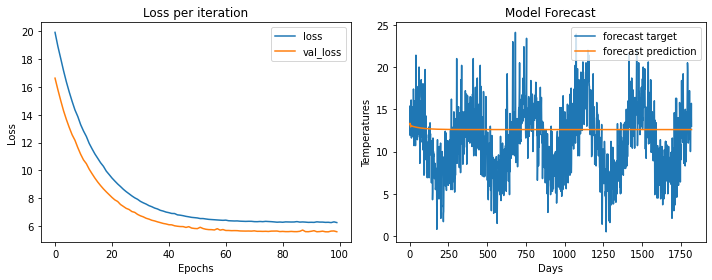

In [24]:
# ----------------------------------------------------------------------------* 
# • Model 1: Autoregressive Linear Model  
# ----------------------------------------------------------------------------*
# build model 
model = buildModel(T, D,'autoregressive')
model.summary()
# train the Model
r = trainModel(model, X, Y, N, autoregressive=True)

# Forecast future values 
# (use only self-predictions for making future predictions)
# Plot loss per iteration and Forecast predictions
forecastPrediction(X, Y, N, model, r)

In [25]:
# RNN/LSTM/GRU model
# let's reshape the data
X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
print("X.shape", X.shape)

X.shape (3640, 10, 1)


Building Simple RNN Model...
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 dense_10 (Dense)            (None, 10, 1)             2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Now making future Forecast predictions...



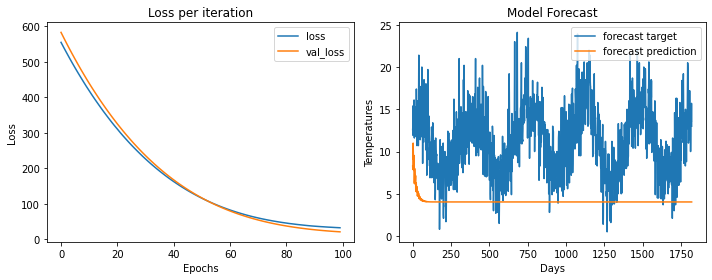

In [26]:
# ----------------------------------------------------------------------------* 
# • Model 2: SimpleRNN 
# ----------------------------------------------------------------------------*
# build model 
model2 = buildModel(T, D,'SimpleRNN')
model2.summary()
# train the Model
r = trainModel(model2, X, Y, N)

# Forecast future values 
# (use only self-predictions for making future predictions)
# Plot loss per iteration and Forecast predictions
forecastPrediction(X, Y, N, model2, r)

Building Gated Recurrent Units Model...
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 dense_11 (Dense)            (None, 10, 1)             2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Now making future Forecast predictions...



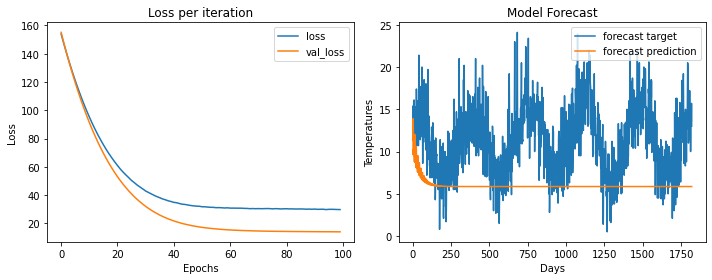

In [27]:
# ----------------------------------------------------------------------------* 
# • Model 3: GRU 
# ----------------------------------------------------------------------------*
# build model 
model3 = buildModel(T, D,'GRU')
model3.summary()
# train the Model
r = trainModel(model3, X, Y, N)
# Forecast future values 
# Plot loss per iteration and Forecast predictions
forecastPrediction(X, Y, N, model3, r)

Building Long Short-Term Memory Model...
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 dense_12 (Dense)            (None, 10, 1)             2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Now making future Forecast predictions...



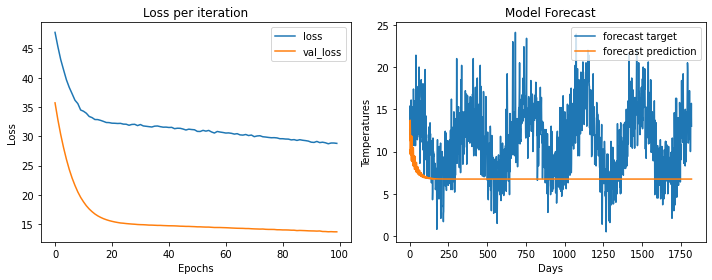

In [28]:
# ----------------------------------------------------------------------------* 
# • Model 4: LSTM
# ----------------------------------------------------------------------------*
# build model 
model4 = buildModel(T, D,'LSTM')
model4.summary()
# train the Model
r = trainModel(model4, X, Y, N)
# Forecast future values 
# Plot loss per iteration and Forecast predictions
forecastPrediction(X, Y, N, model4, r)

Building LSTM + Global Max Pooling Model...
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 dense_13 (Dense)            (None, 10, 1)             2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Now making future Forecast predictions...



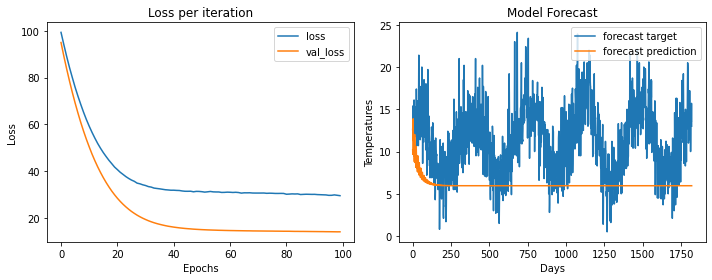

In [29]:
# ----------------------------------------------------------------------------* 
# • Model 5: LSTM + Global Max Pooling
# ----------------------------------------------------------------------------*
# build model 
model5 = buildModel(T, D,'LSTMGMP')
model5.summary()
# train the Model
r = trainModel(model5, X, Y, N)
# Forecast future values 
# Plot loss per iteration and Forecast predictions
forecastPrediction(X, Y, N, model5, r)

In [15]:
# Model 1 starts by flattening the data and then runs it through two Dense layer
# changing the number of epochs didn't make much chnage as the loss of train 
# and accuracy stayed relatively constaint from 75 epoches and above

# in overl testing -- Trying different optimizers, epochs, and 
# number of units in the hidden layer, Autoregressive Linear Model and SimpleRNN  
# provided the best result with lowest 
# gap betwen the loss on training data and validation data
# The large gap in other model seem to be indacting an overfit